In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
import tensorflow as tf

from IPython.display import display 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### load images

In [3]:
img_name = glob.glob('../sample_image/pracimages/org/*.png')
img_name.sort()
img_name

['../sample_image/pracimages/org/01_113.png',
 '../sample_image/pracimages/org/02_114.png',
 '../sample_image/pracimages/org/03_115.png',
 '../sample_image/pracimages/org/04_115.png',
 '../sample_image/pracimages/org/05_118.png',
 '../sample_image/pracimages/org/06_120.png',
 '../sample_image/pracimages/org/07_123.png',
 '../sample_image/pracimages/org/08_113.png',
 '../sample_image/pracimages/org/09_114.png',
 '../sample_image/pracimages/org/10_115.png',
 '../sample_image/pracimages/org/11_115.png',
 '../sample_image/pracimages/org/12_118.png',
 '../sample_image/pracimages/org/13_120.png',
 '../sample_image/pracimages/org/14_123.png',
 '../sample_image/pracimages/org/15_113.png',
 '../sample_image/pracimages/org/16_114.png',
 '../sample_image/pracimages/org/17_115.png',
 '../sample_image/pracimages/org/18_116.png',
 '../sample_image/pracimages/org/19_118.png',
 '../sample_image/pracimages/org/20_120.png',
 '../sample_image/pracimages/org/21_123.png',
 '../sample_image/pracimages/org/2

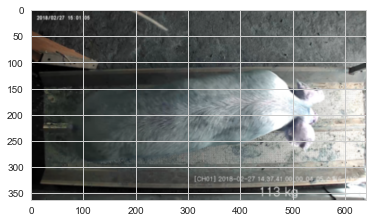

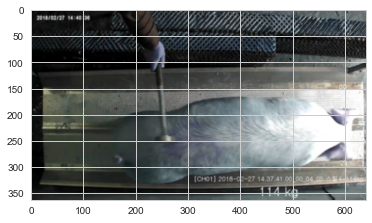

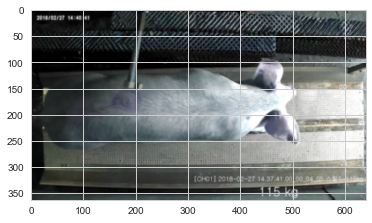

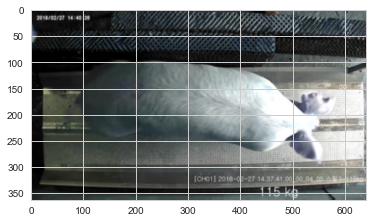

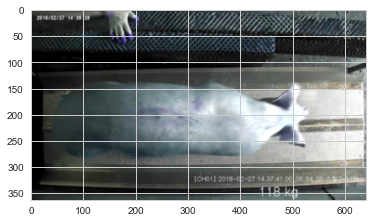

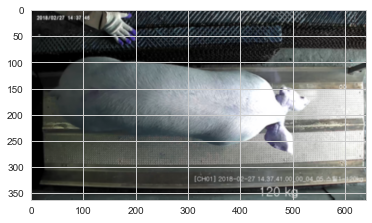

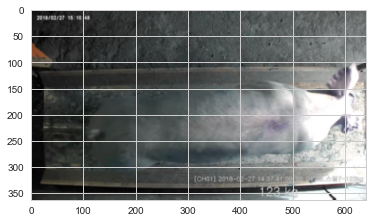

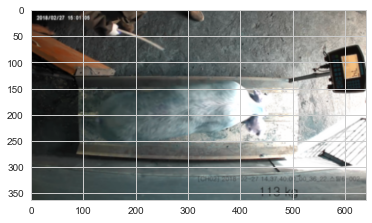

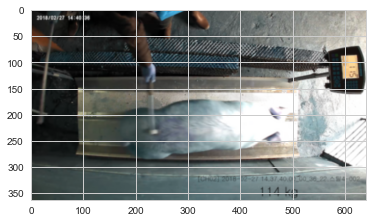

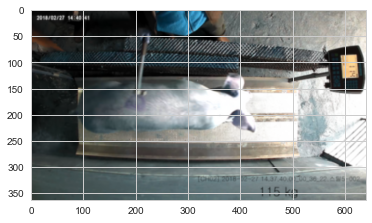

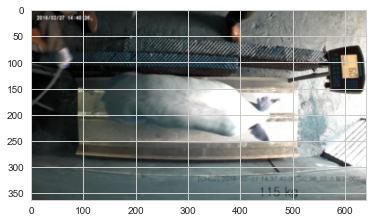

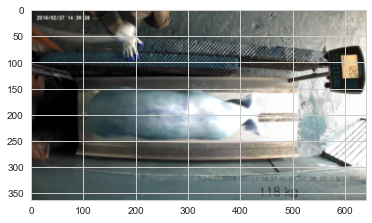

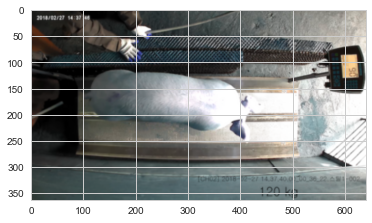

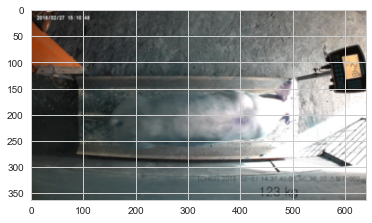

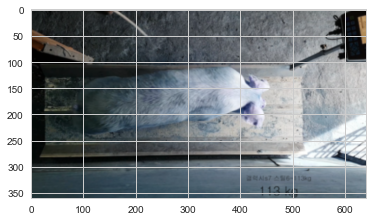

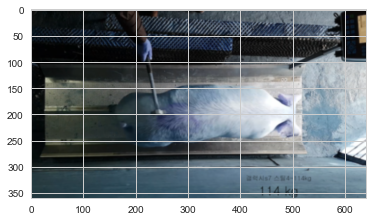

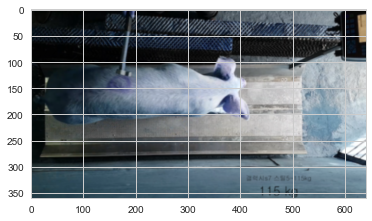

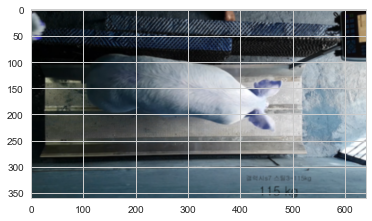

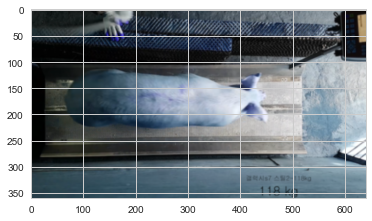

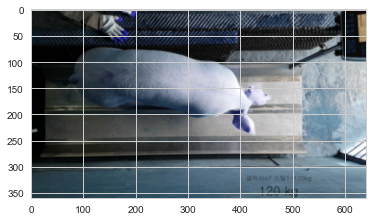

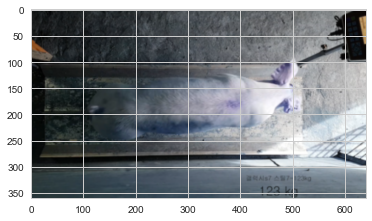

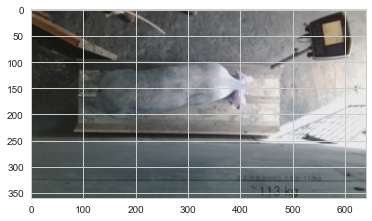

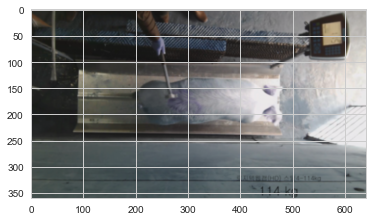

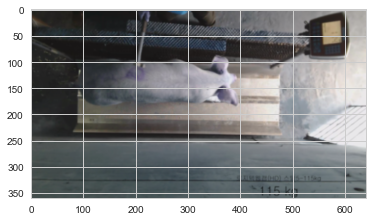

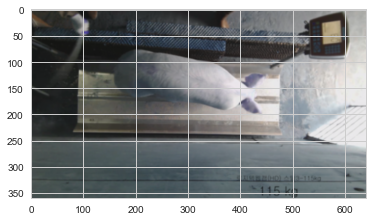

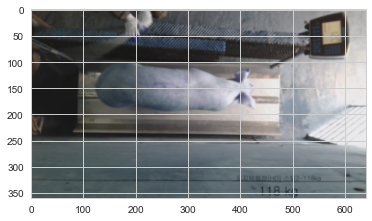

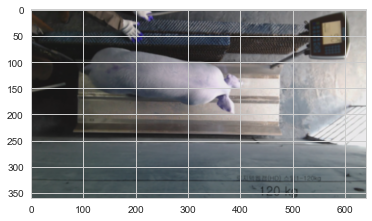

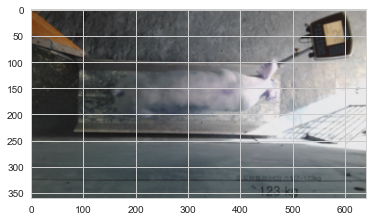

In [4]:
pid = []## -> pigs` ids
weight = []  ## -> target 
images = []
for i, img in enumerate(img_name):
    pid.append("p" + img_name[i][31:33])
    weight.append(img_name[i][34:37])
    
    img = cv2.imread(img)
    if i % 100 == 0:
        plt.imshow(img, interpolation='bicubic')
        plt.show()
    images.append(img)
    
weight = np.array(weight).astype(int)

### crop the images

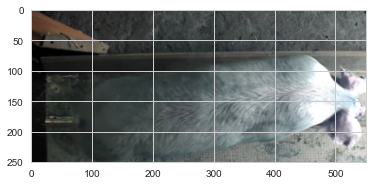

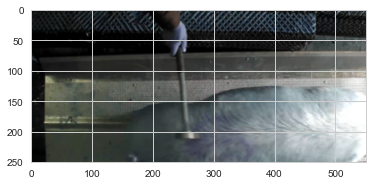

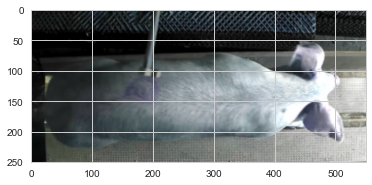

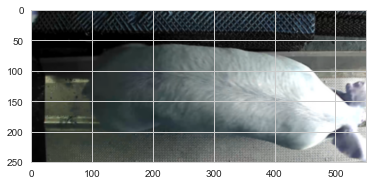

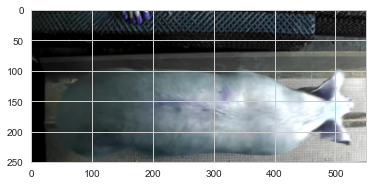

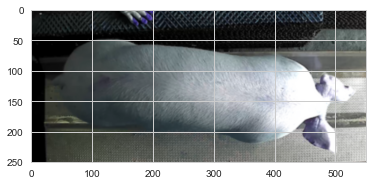

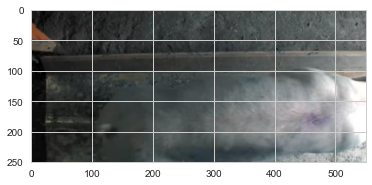

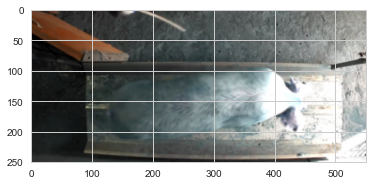

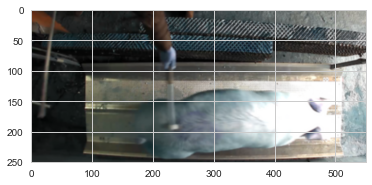

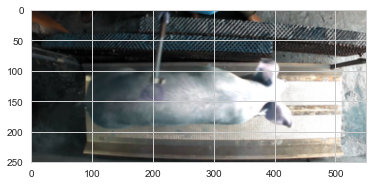

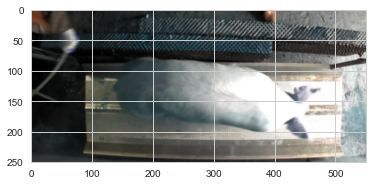

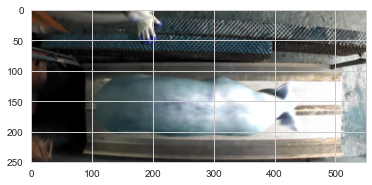

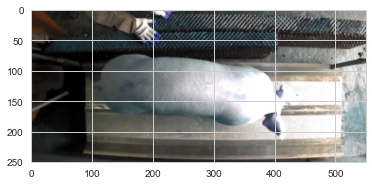

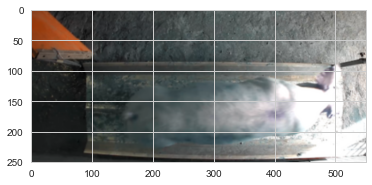

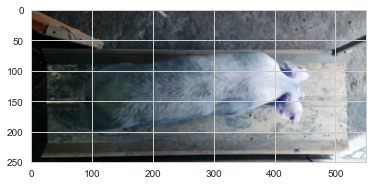

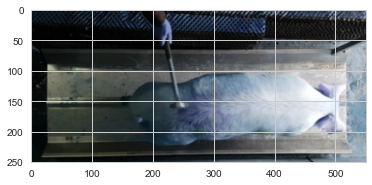

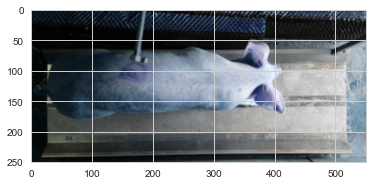

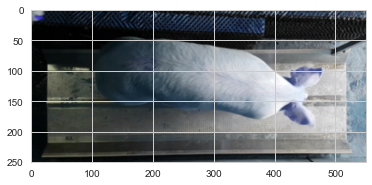

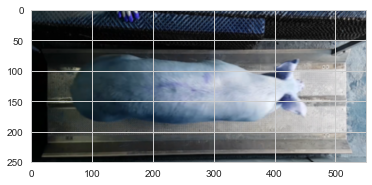

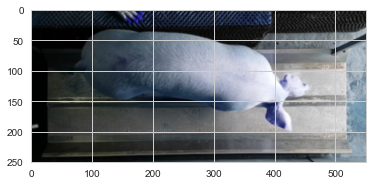

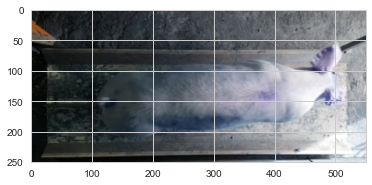

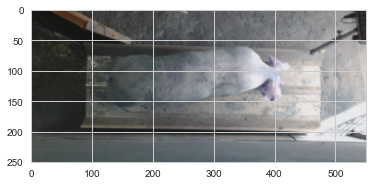

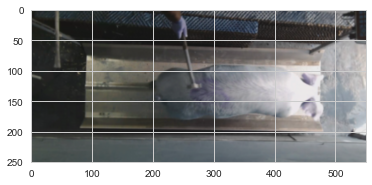

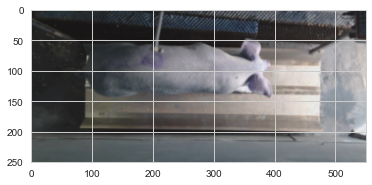

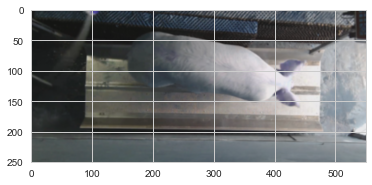

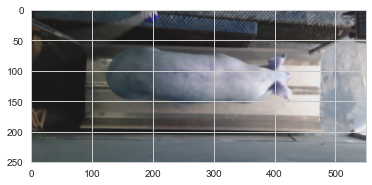

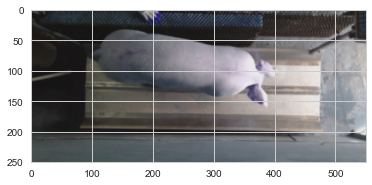

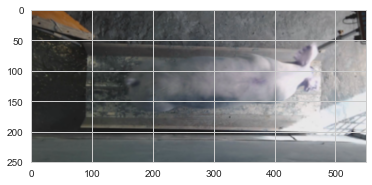

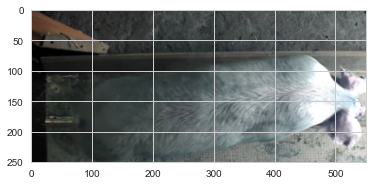

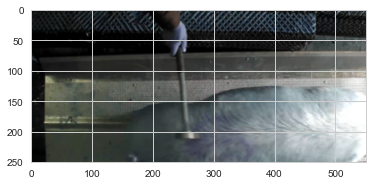

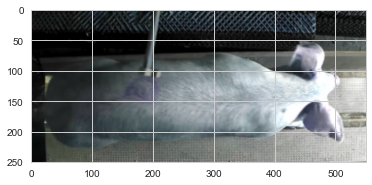

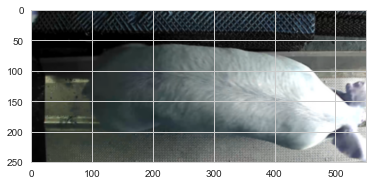

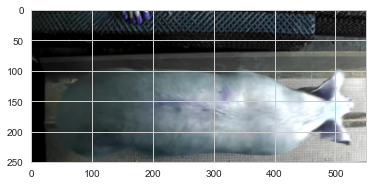

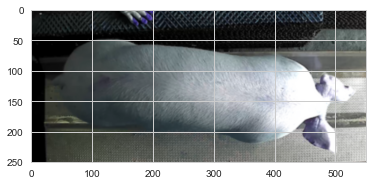

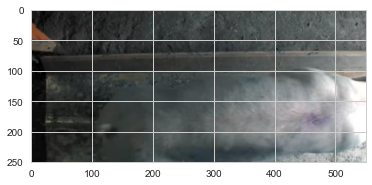

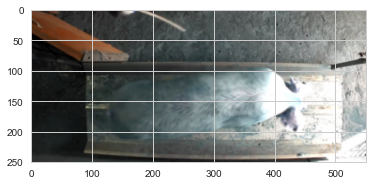

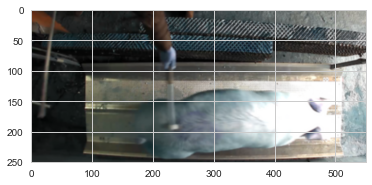

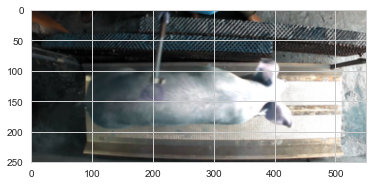

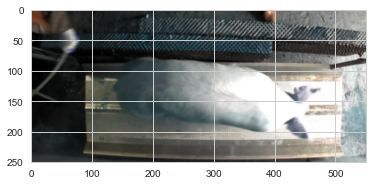

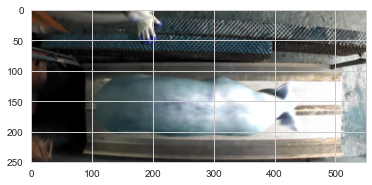

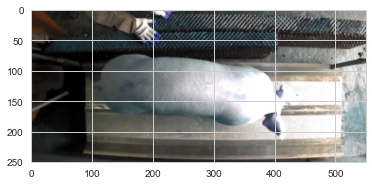

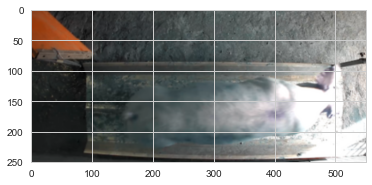

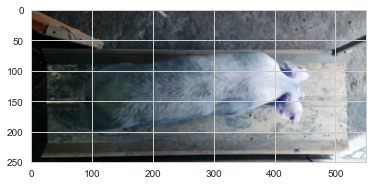

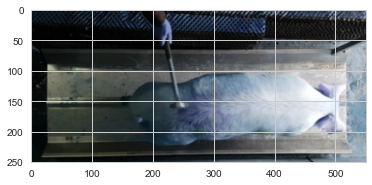

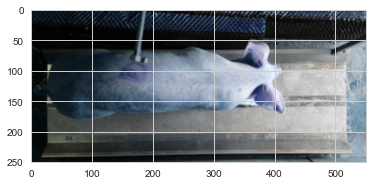

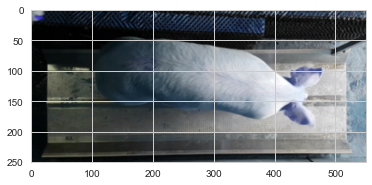

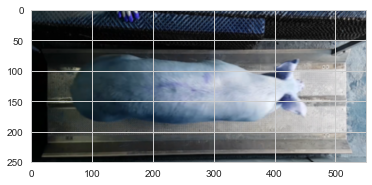

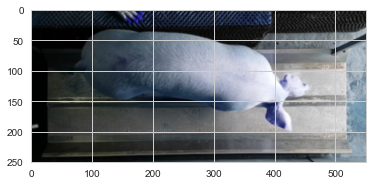

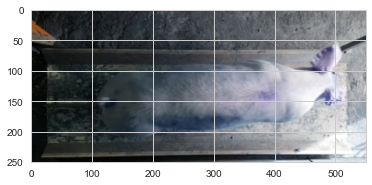

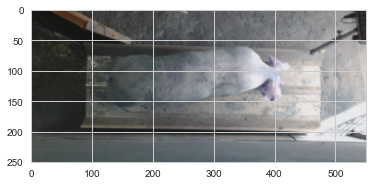

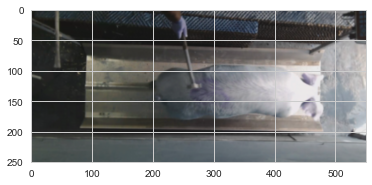

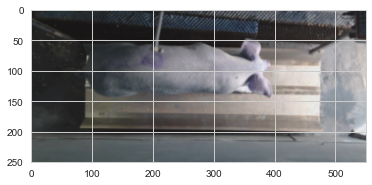

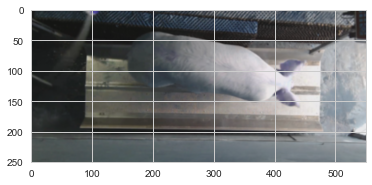

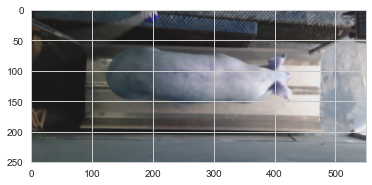

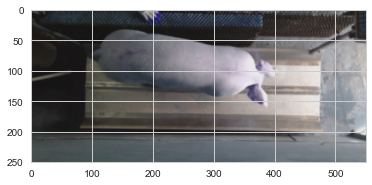

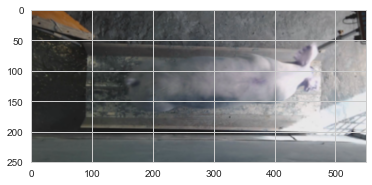

In [6]:
crop_img = []
top = 40
left = 0
for img in images:
    img = img[top:top+250, left:left+550]
    plt.imshow(img, interpolation='bicubic')
    plt.show()
    crop_img.append(img)

# make pickle 
with open("../pickle/org_crop_img.bin", 'wb') as f:
    pickle.dump(crop_img, f)
del images, crop_img
# read pickle file
with open("../pickle/org_crop_img.bin", "rb") as f:
    crop_img = pickle.load(f)
    

for i, img in enumerate(crop_img):
    if i % 100 == 0:
        plt.imshow(img, interpolation='bicubic')
        plt.show()

### Store with labels 

In [7]:
df = pd.DataFrame(data={'pid': pid, 'weight': weight, 'image':crop_img})
df.sort_values('pid', inplace=True)
df.reset_index(inplace=True, drop=True)
df.tail()

image  pid  weight
23  [[[27, 26, 22], [27, 26, 22], [26, 26, 21], [2...  p24     115
24  [[[19, 22, 20], [19, 22, 20], [20, 24, 21], [2...  p25     115
25  [[[27, 25, 24], [27, 25, 25], [28, 26, 25], [2...  p26     118
26  [[[83, 74, 66], [85, 77, 69], [88, 82, 73], [8...  p27     120
27  [[[120, 67, 30], [119, 66, 29], [119, 66, 28],...  p28     123

In [8]:
df.tail()

image  pid  weight
23  [[[27, 26, 22], [27, 26, 22], [26, 26, 21], [2...  p24     115
24  [[[19, 22, 20], [19, 22, 20], [20, 24, 21], [2...  p25     115
25  [[[27, 25, 24], [27, 25, 25], [28, 26, 25], [2...  p26     118
26  [[[83, 74, 66], [85, 77, 69], [88, 82, 73], [8...  p27     120
27  [[[120, 67, 30], [119, 66, 29], [119, 66, 28],...  p28     123

#### load cropped samples

In [12]:
with open("../sample_image/sample_crop_df.bin", "rb") as f:
    crop_img = pickle.load(f)

In [15]:
print(crop_img.shape)
crop_img.tail(1)

(560, 4)


pid  weight                                             images  \
559  p28img20  124.12  [[[103, 108, 107], [103, 108, 107], [103, 108,...   

                                           crop_images  
559  [[[103, 108, 107], [103, 108, 107], [103, 108,...

### store as tfrecord file

- sample image를 미리 crop 해서 df를 binary 파일로 만들어 놓기 보다 바로 sample_image 디렉토리에 넣어두기만 하면, 이 notebook 파일을 실행해서, tfrecord로 변환 할 수 있게 만드는 것이 더 좋은 방법 일 듯 합니다. 

- 파일을 불러와서 crop하고 3차원 배열로 변환한 것을 df에 넣고, 아래로 바로 가


In [31]:
#########train/test split -> 8:2
## 560 * 0.8 == 448 for train 
## 560 * 0.2 == 112 for test
train_len = int(len(crop_img.crop_images) * 0.8)
test_len= len(crop_img.crop_images) - train_len
print(test_len)

def _float64_feature(value): # for label 
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _bytes_feature(value): # for img 
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

train_file = "../sample_image/preprocessed/train.tfrecord"
test_file = "../sample_image/preprocessed/test.tfrecord"

train_writer = tf.python_io.TFRecordWriter(train_file)
test_writer = tf.python_io.TFRecordWriter(test_file)


for i, img in enumerate(crop_img.crop_images):
        
    if i < train_len : ## train_set 
        
        print('Train data: {}/{}'.format(i+1, train_len))
        # create features
        label = crop_img.weight[i]
        feature = {'train/label': _float64_feature(label),
                   'train/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}
                                            ## tf.compat.as_bytes == convert data to utf-8 encoded bytes 
        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        # Serialize to string and write on the file
        train_writer.write(example.SerializeToString())
        
    else : ## test set 
        print('test data: {}/{}'.format((i - (train_len - 1)), test_len))                
        label = crop_img.weight[i]
        feature = {'test/label': _float64_feature(label),
                   'test/image': _bytes_feature(tf.compat.as_bytes(img.tostring()))}


        example = tf.train.Example(features=tf.train.Features(feature=feature))

        test_writer.write(example.SerializeToString())

train_writer.close()
test_writer.close()

112
Train data: 1/448
Train data: 2/448
Train data: 3/448
Train data: 4/448
Train data: 5/448
Train data: 6/448
Train data: 7/448
Train data: 8/448
Train data: 9/448
Train data: 10/448
Train data: 11/448
Train data: 12/448
Train data: 13/448
Train data: 14/448
Train data: 15/448
Train data: 16/448
Train data: 17/448
Train data: 18/448
Train data: 19/448
Train data: 20/448
Train data: 21/448
Train data: 22/448
Train data: 23/448
Train data: 24/448
Train data: 25/448
Train data: 26/448
Train data: 27/448
Train data: 28/448
Train data: 29/448
Train data: 30/448
Train data: 31/448
Train data: 32/448
Train data: 33/448
Train data: 34/448
Train data: 35/448
Train data: 36/448
Train data: 37/448
Train data: 38/448
Train data: 39/448
Train data: 40/448
Train data: 41/448
Train data: 42/448
Train data: 43/448
Train data: 44/448
Train data: 45/448
Train data: 46/448
Train data: 47/448
Train data: 48/448
Train data: 49/448
Train data: 50/448
Train data: 51/448
Train data: 52/448
Train data: 53/44

test data: 75/112
test data: 76/112
test data: 77/112
test data: 78/112
test data: 79/112
test data: 80/112
test data: 81/112
test data: 82/112
test data: 83/112
test data: 84/112
test data: 85/112
test data: 86/112
test data: 87/112
test data: 88/112
test data: 89/112
test data: 90/112
test data: 91/112
test data: 92/112
test data: 93/112
test data: 94/112
test data: 95/112
test data: 96/112
test data: 97/112
test data: 98/112
test data: 99/112
test data: 100/112
test data: 101/112
test data: 102/112
test data: 103/112
test data: 104/112
test data: 105/112
test data: 106/112
test data: 107/112
test data: 108/112
test data: 109/112
test data: 110/112
test data: 111/112
test data: 112/112
